In [2]:
import pandas as pd
import numpy as pn
import librosa
import matplotlib.pyplot as plt
import librosa.display

from src import *
from scipy import signal
import soundfile as sf
from scipy.ndimage import gaussian_filter
import librosa.feature
import os

In [3]:
def compare_before_after(before, after, sr, title1 = 'Before', title2 = 'After'):
    fig, ax = plt.subplots(2,1, figsize = (14,10))

    ax[0].set_title(title1)
    img1 = librosa.display.specshow(before, sr=sr, ax=ax[0], x_axis='time', y_axis='hz')
    plt.colorbar(img1, ax=ax[0], format='%+2.0f dB')

    ax[1].set_title(title2)
    img2 = librosa.display.specshow(after, sr=sr, ax=ax[1], x_axis='time', y_axis='hz')
    plt.colorbar(img2, ax=ax[1], format='%+2.0f dB')
    plt.style.use('default')

    plt.tight_layout()
    plt.show()

def spectral_substraction(noise_sample, y, sr, factor = 1, smoothing = None, return_audio = False):
    y_spectrum = librosa.stft(y)
    y_spectrum_db = librosa.amplitude_to_db(np.abs(y_spectrum))
    phase = np.angle(y_spectrum)
    noise_start = int(noise_sample[0]*sr)
    noise_end = int(noise_sample[1]*sr)
    noise_sample = y[noise_start:noise_end]
    noise_spectrum = librosa.stft(noise_sample)
    noise_power = np.mean(np.abs(noise_spectrum)**2, axis=1)

    if smoothing:
        noise_power = gaussian_filter(noise_power, sigma=smoothing)
    noise_power = noise_power.reshape((-1,1))

    spectrum_power = np.abs(y_spectrum)**2
    spectrum_power_cleaned = spectrum_power - factor * noise_power
    spectrum_power_cleaned = np.maximum(spectrum_power_cleaned, 0)
    spectrum_cleaned_db = librosa.power_to_db(spectrum_power_cleaned)

    if return_audio:
        magnitude = librosa.db_to_amplitude(spectrum_cleaned_db)
        complex_spectrum = magnitude * np.exp(1j * phase)
        return librosa.istft(complex_spectrum)

    return spectrum_cleaned_db

def apply_bandpass(y, sr, lowcut, highcut, order, return_audio = False):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', output = 'ba')
    y_filtered = signal.filtfilt(b, a, y)

    if return_audio:
        return y_filtered

    y_filtered_spectrum = librosa.stft(y_filtered)
    y_filtered_spectrum_db = librosa.amplitude_to_db(y_filtered_spectrum)
    return y_filtered_spectrum_db

def apply_threshold(y, sr, cutoff, return_audio = False):
    y_spectrum = librosa.stft(y)
    y_spectrum_db = librosa.amplitude_to_db(np.abs(y_spectrum))
    y_spectrum_db[y_spectrum_db < cutoff] = -80

    phase = np.angle(y_spectrum)
    if return_audio:
        magnitude = librosa.db_to_amplitude(y_spectrum_db)
        complex_spectrum = magnitude * np.exp(1j * phase)
        # return librosa.istft(complex_spectrum)

    return y_spectrum_db

def examine_features(y, sr):
    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8, n_fft=512, hop_length=512, fmin= 4000, fmax = 8000)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    rms = librosa.feature.rms(y=y)[0]

    # Create subplots
    plt.figure(figsize=(15, 10))

    # Plot each feature
    plt.subplot(3, 2, 1)
    plt.plot(centroid)
    plt.title('Spectral Centroid')

    plt.subplot(3, 2, 2)
    plt.plot(bandwidth)
    plt.title('Spectral Bandwidth')

    plt.subplot(3, 2, 3)
    plt.plot(rolloff)
    plt.title('Spectral Rolloff')

    plt.subplot(3, 2, 4)
    plt.plot(zcr)
    plt.title('Zero Crossing Rate')

    plt.subplot(3, 2, 5)
    plt.plot(rms)
    plt.title('RMS Energy')

    plt.tight_layout()
    plt.show()

def create_combined_features(y, sr):
    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8, n_fft=512, hop_length=512, fmin= 4000, fmax = 8000)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    rms = librosa.feature.rms(y=y)[0]

    feature_dict = {
        'mfcc_means': np.mean(mfccs, axis=1),  # 13 values
        'mfcc_stds': np.std(mfccs, axis=1),    # 13 values
        'centroid_mean': np.mean(centroid),     # 1 value
        'centroid_std': np.std(centroid),       # 1 value
        'rolloff_mean': np.mean(rolloff),
        'rolloff_std': np.std(rolloff),
        'rms_mean': np.mean(rms),
        'rms_std': np.std(rms)
    }

    return feature_dict

def isolate_calls(origin,save = False, save_folder = ''):
    y, sr = librosa.load(origin)
    calls = []
    y = np.abs(y)
    gen_mean = np.mean(y)
    gen_std = np.std(y)
    threshold = gen_mean + 4 * gen_std
    potential_calls = np.where(y > threshold)[0]
    call_end = 0
    isolated_calls = []
    for call in potential_calls:
        if call < call_end:
            continue
        jump = 0.5
        ahead_mean = np.mean(y[call + int(jump*sr):call + int((jump+0.2)*sr)])
        while ahead_mean > gen_mean:
            jump += 0.2
            ahead_mean = np.mean(y[call + int(jump*sr):call + int((jump+0.2)*sr)])
        call_end = call + int(jump*sr)
        calls.append([call, call_end])

    isolated_calls = [y[call[0]:call[1]] for call in calls]
    if save:
        for call, counter in enumerate(isolated_calls,1):
            file_name = save_folder + origin + f'_split_{counter}.wav'
            sf.write(file = file_name,data = call, samplerate = sr)


    return isolated_calls


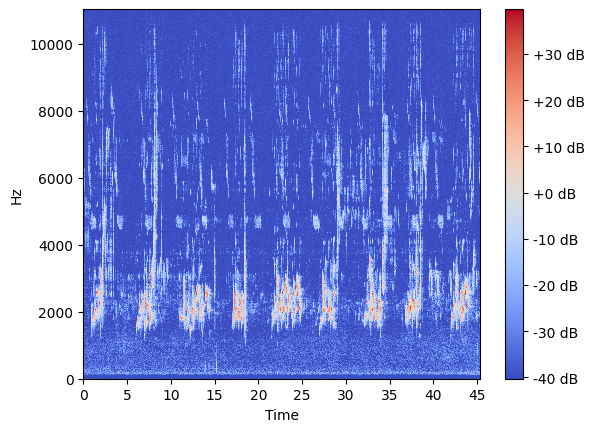

In [4]:
y, sr = librosa.load("../data/raw/789465_Turdus_merula_2023-03-30_Germany.mp3")
y = spectral_substraction([0,0.5], y, sr, factor = 0.5, smoothing = 2, return_audio=True)
y_spectrum = librosa.stft(y)
y_spectrum_db = librosa.amplitude_to_db(np.abs(y_spectrum))
librosa.display.specshow(y_spectrum_db, sr=sr, x_axis='time', y_axis='hz', cmap= 'coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.show()